# Because BraTS20_Training_270 may have doubtful ground truth label, conduct the analysis to verify if the study result will be different with the alternative label of BraTS20_Training_270 being GBM


Report the main study result on physicians' task performance with and without the assistance of AI prediction and explanation

For details, see Suppelemental S2 Section 3.

Use xai25_alternative270gt.csv instead of xai25.csv by chaning the ground truth label of BraTS20_Training_270 from 0 to 1.

In [1]:
from base_code import *
from scipy.stats import friedmanchisquare, wilcoxon
from statannot import add_stat_annotation

valid_data = pd.read_csv('../neurosurgeon35_data/neurosurgeon35.csv', index_col='Respondent ID')
xai25 = pd.read_csv('../computational_data/xai25_alternative270gt.csv')
dr_wise_acc, num_mri = get_drwise_perf_metric(valid_data, xai25)
# need XAI level
will_check_xai =  valid_data.filter(regex='button in the AI system').replace({"Yes":1, "No":0})
need_xai_rate_drwise = dict()
for drID in will_check_xai.index:
    row_lst = will_check_xai.loc[drID].dropna().values
    need_xai_rate_drwise[drID] = sum(row_lst) /len(row_lst)
need_xai_rate_drwise = dict(sorted(need_xai_rate_drwise.items(), key=lambda item: item[1])) 

# Explanation quality level
xai_qual = valid_data.filter(regex='How closely does the highlighted area of the color map match with your clinical judgment?').fillna(np.nan).astype(float)
xai_qual_drwise = dict()
xai_qual_drwise_std = dict()

for drID in xai_qual.index:
    row_lst = xai_qual.loc[drID].dropna().values
    xai_qual_drwise[drID] = sum(row_lst) /len(row_lst)
    xai_qual_drwise_std[drID] = np.std(row_lst)
xai_qual_drwise = dict(sorted(xai_qual_drwise.items(), key=lambda item: item[1])) 

# merge dr_wise_acc, num_mri, need_xai_rate_drwise, and xai_qual_drwise
dr_wise_acc.index.name = 'Respondent ID'
num_mri.index.name = 'Respondent ID'
num_mri = num_mri.rename(columns = {'dr': 'MRI_DR', 'AI': 'MRI_DR+AI', 'XAI': 'MRI_DR+XAI'})
dr_wise_acc = dr_wise_acc.merge(num_mri, how = 'left', left_index= True, right_index = True)

dr_wise_acc['XAI Qual'] = pd.Series(xai_qual_drwise)
dr_wise_acc['XAI Qual Std'] = pd.Series(xai_qual_drwise_std)
dr_wise_acc['Need XAI'] = pd.Series(need_xai_rate_drwise)
dr_wise_acc = dr_wise_acc.rename(columns = {'dr': 'DR', 'AI': 'DR+AI', 'XAI': 'DR+XAI'})
dr_wise_acc = dr_wise_acc.reset_index()

/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# 1. Physicians' task accuracy in the three conditions

In [3]:
dr_acc, ai_acc, xai_acc  =  dr_wise_acc['DR'], dr_wise_acc['DR+AI'], dr_wise_acc['DR+XAI']
acc_df = pd.DataFrame.from_dict({'dr_acc': dr_acc, 'ai_acc': ai_acc, 'xai_acc': xai_acc, 'id': dr_wise_acc['Respondent ID']}).set_index(keys='id')
acc_melt = pd.melt(acc_df.reset_index(), id_vars='id', value_vars=acc_df.columns)

print(rp.summary_cont(pd.Series(dr_acc)))
print(rp.summary_cont(pd.Series(ai_acc)))
print(rp.summary_cont(pd.Series(xai_acc)))

print('\n  \n')
# check ANOVA assumption 1: Univariate normality
print(pg.normality(dr_acc, method = 'shapiro')    )                                
print(pg.normality(ai_acc, method = 'shapiro')   )
print(pg.normality(xai_acc, method = 'shapiro')  )

# check Anova assuption 2: sphericity
# https://pingouin-stats.org/generated/pingouin.sphericity.html
print(pg.sphericity(data=acc_melt, dv='value', within='variable', subject='id', method = 'mauchly'))




  Variable     N    Mean      SD      SE  95% Conf.  Interval
0       DR  35.0  0.8676  0.0838  0.0142     0.8388    0.8963


  Variable     N    Mean      SD      SE  95% Conf.  Interval
0    DR+AI  35.0  0.9102  0.0656  0.0111     0.8876    0.9327


  Variable     N    Mean      SD      SE  95% Conf.  Interval
0   DR+XAI  35.0  0.9183  0.0607  0.0103     0.8975    0.9392

  

           W      pval  normal
DR  0.899199  0.003763   False
              W      pval  normal
DR+AI  0.929738  0.027478   False
              W      pval  normal
DR+XAI  0.93238  0.032942   False
SpherResults(spher=True, W=1169.0669916264521, chi2=-233.11072179815108, dof=2, pval=1.0)


(array([ 2.,  0.,  2.,  0.,  1., 10.,  6., 10.,  1.,  3.]),
 array([0.64 , 0.676, 0.712, 0.748, 0.784, 0.82 , 0.856, 0.892, 0.928,
        0.964, 1.   ]),
 <BarContainer object of 10 artists>)

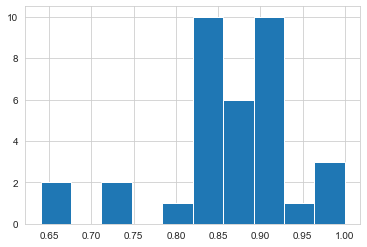

In [4]:
# visualize the dist since normality failed
plt.hist(dr_acc, bins =10)

(array([1., 0., 1., 0., 5., 9., 0., 7., 6., 6.]),
 array([0.72 , 0.748, 0.776, 0.804, 0.832, 0.86 , 0.888, 0.916, 0.944,
        0.972, 1.   ]),
 <BarContainer object of 10 artists>)

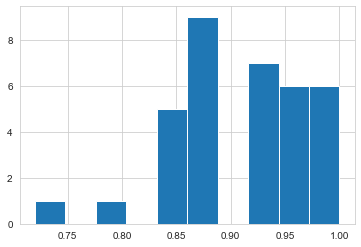

In [5]:
plt.hist(ai_acc, bins =10)

(array([1., 1., 0., 4., 0., 6., 9., 1., 7., 6.]),
 array([0.76 , 0.784, 0.808, 0.832, 0.856, 0.88 , 0.904, 0.928, 0.952,
        0.976, 1.   ]),
 <BarContainer object of 10 artists>)

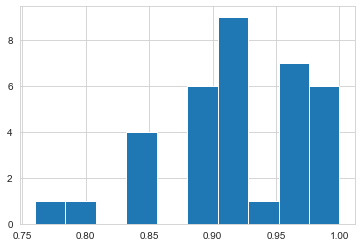

In [6]:
plt.hist(xai_acc, bins =10)

In [7]:
# report in manuscript Table 2
cdt = ['DR', 'DR+AI', 'DR+XAI']

for i, acc in enumerate([dr_acc, ai_acc, xai_acc]):
    adict = acc.describe().to_dict()
    print('\\ul{{{}}} & {:.0f} & ${:.2f}\pm{:.2f}$ & {:.2f} & {:.2f}& {:.2f}& {:.2f}& {:.2f} \\\\'.format(cdt[i], adict['count'],adict['mean']*100,adict['std']*100,
                                                           adict['min']*100, adict['25%']*100, adict['50%']*100, adict['75%']*100, adict['max']*100))


\ul{DR} & 35 & $86.76\pm8.38$ & 64.00 & 84.00& 88.00& 92.00& 100.00 \\
\ul{DR+AI} & 35 & $91.02\pm6.56$ & 72.00 & 88.00& 92.00& 96.00& 100.00 \\
\ul{DR+XAI} & 35 & $91.83\pm6.07$ & 76.00 & 88.00& 92.00& 96.00& 100.00 \\


In [9]:
# Friedman significance test
dr_acc, ai_acc, xai_acc  =  dr_wise_acc['DR'], dr_wise_acc['DR+AI'], dr_wise_acc['DR+XAI']
stat_acc, p_acc = friedmanchisquare(*[dr_acc, ai_acc, xai_acc])
print("Friedman test",stat_acc, p_acc)

# post-hoc test, reporting result
w, p1 = wilcoxon(np.array(ai_acc), np.array(dr_acc))#, alternative  = 'greater')
print(w, p1*3)
w, p2 = wilcoxon(np.array(xai_acc), np.array(dr_acc))#, alternative  = 'greater')
print(w, p2*3)
w, p3 = wilcoxon(np.array(xai_acc) ,np.array(ai_acc))# alternative  = 'greater')
print(w, p3*3)

Friedman test 21.799999999999955 1.8458233995780965e-05
12.0 0.003922687793387315
6.0 0.0009840213179914492
19.0 0.6009075200114936


In [10]:
# Report common language effect size
# https://pingouin-stats.org/generated/pingouin.compute_effsize.html
# https://www.frontiersin.org/articles/10.3389/fpsyg.2013.00863/full
print("Common Language Effect Size", pg.compute_effsize(dr_wise_acc['DR+AI'].values, dr_wise_acc['DR'].values, paired = True, eftype='CLES'))
print("Common Language Effect Size", pg.compute_effsize(dr_wise_acc['DR+XAI'].values, dr_wise_acc['DR+AI'].values, paired = True, eftype='CLES'))
print("Common Language Effect Size", pg.compute_effsize(dr_wise_acc['DR+XAI'].values, dr_wise_acc['DR'].values, paired = True, eftype='CLES'))


Common Language Effect Size 0.653469387755102
Common Language Effect Size 0.5387755102040817
Common Language Effect Size 0.6922448979591836


/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/seaborn/relational.py:601: UserWarning: You passed a edgecolor/edgecolors ('face') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scout = ax.scatter(scout_x, scout_y, **kws)
/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/seaborn/relational.py:644: UserWarning: You passed a edgecolor/edgecolors ('face') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)
/Users/root202/Software/anaconda3/envs/posthoc-eval/lib/python3.8/site-packages/seaborn/relational.py:601: UserWarning: You passed a edgecolor/edgecolors ('face') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scout = ax.scatter(

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
dr_acc v.s. ai_acc: Wilcoxon test (paired samples) with Bonferroni correction, P_val=3.923e-03 stat=1.200e+01
Using zero_method  wilcox
ai_acc v.s. xai_acc: Wilcoxon test (paired samples) with Bonferroni correction, P_val=6.009e-01 stat=1.900e+01
Using zero_method  wilcox
dr_acc v.s. xai_acc: Wilcoxon test (paired samples) with Bonferroni correction, P_val=9.840e-04 stat=6.000e+00


Text(30.375, 0.5, 'Accuracy')

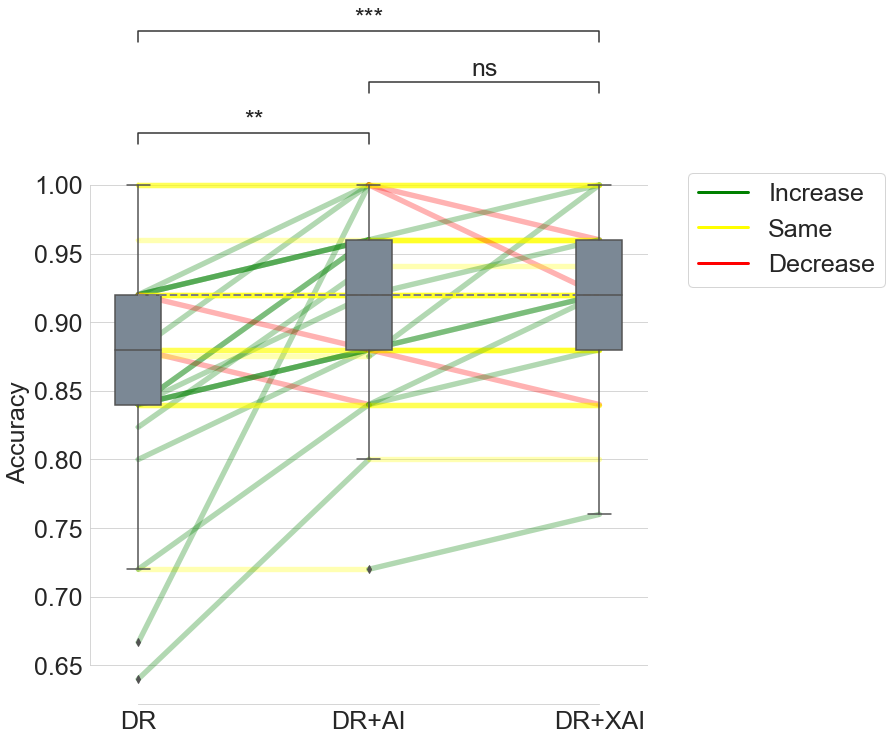

In [12]:
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 25})
# create long table for accuracy
acc_df = pd.DataFrame.from_dict({'dr_acc': dr_acc, 'ai_acc': ai_acc, 'xai_acc': xai_acc, 'id': valid_data.index}).set_index(keys='id')
acc_melt = pd.melt(acc_df.reset_index(), id_vars='id', value_vars=acc_df.columns)
ai_a = 23/25
order = ['dr_acc', 'ai_acc', 'xai_acc']
fig, ax = plt.subplots(figsize = (10,10))
ax = pg.plot_paired(ax = ax, data=acc_melt, dv='value', within='variable', subject='id', dpi=150, pointplot_kwargs={'alpha': 0.3, 'scale': 2, 'marker': '+'}, colors = ['green', 'yellow','red','orange'], boxplot_in_front=True, order = order)
ax.plot(['DR', 'DR+AI', 'DR+XAI'], [ai_a]*3, '--', color='gray', linewidth=2, markersize=12)

# add significance for boxplot
# Ref: https://stackoverflow.com/questions/36578458/how-does-one-insert-statistical-annotations-stars-or-p-values-into-matplotlib/37518947#37518947
p_values = [p1*3, p2*3, p3*3]
add_stat_annotation(ax, data=acc_melt, x='variable', y= 'value', order=order,
                    box_pairs=[("ai_acc", "dr_acc"), ("xai_acc", "dr_acc"), ("xai_acc", "ai_acc")],
                    test='Wilcoxon', stats_params ={'alternative':'two-sided'}, text_format='star', loc='outside', verbose=2)
ax.set_xticklabels(['DR', "DR+AI", 'DR+XAI'])

# custom legend of line colors
lw = 3
custom_lines = [Line2D([0], [0], color='green', lw=lw),
                Line2D([0], [0], color='yellow', lw=lw),
                Line2D([0], [0], color="red", lw=lw)]

ax.legend(custom_lines, ['Increase', 'Same', 'Decrease'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("")

plt.ylabel("Accuracy")
# plt.savefig('../reporting/acc_alternative270gt.pdf', bbox_inches='tight')


# 2. Test for whether complementary doctor-AI task performance was achieved

AI accuracy = 0.88

In [13]:
# complementary doctor-AI performance with AI prediction assistance
pg.ttest(ai_acc, 23/25, alternative = 'greater')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.885982,34,greater,0.809075,"[0.89, inf]",0.149758,0.522,0.005977


In [14]:
# complementary doctor-AI performance with XAI assistance
pg.ttest(xai_acc, 23/25, alternative = 'greater')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.163886,34,greater,0.564604,"[0.9, inf]",0.027702,0.367,0.035497
